# **Lab3 : Photo Mosaic using KNN Clustering**

In [48]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from sklearn.cluster import KMeans

from scipy import spatial

from tqdm import tqdm
import cv2
import os
import random

## Feature Preparation for tile images

Locate the directory containing your tile images dataset. Ensure that the images in this directory have a wide range of colors to create a visually appealing mosaic. List all the image filenames in the directory to `fnames`. ***Select a subset of these filenames to use as tile images, with at least 100 images in total, and assign them to `fnames_mini`.***

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
### START CODE HERE ###
# set seed
random.seed(20)

# path from google drive
directory_path = '/content/drive/MyDrive/Image processing IMG/jerry'
# os.listdir : list ชื่อไฟล์ใน directory
fnames = os.listdir(directory_path)
numImg = len(fnames)

# sample image 20% from total image
fnames_mini = random.sample(fnames, int(0.2*numImg))
print(f"Total image : {len(fnames)} : selected image : {len(fnames_mini)}")

# concate path (directory + list in directory)
img_path = os.path.join(directory_path, fnames_mini[0])
print(f"shape img1 : {(cv2.imread(img_path)).shape}")
# ### END CODE HERE ###

Total image : 897 : selected image : 179
shape img1 : (480, 854, 3)


In [51]:
assert len(fnames_mini) >= 100, "Less than 100 images found in the subset. Ensure the directory has at least 100 images."

### Loading and Resizing Tile Images
Define the size to which all tile images will be resized. This ensures consistency in the dimensions of the tile images.
Iterate over the list of tile image filenames. Resize the image to the predefined `tile_size`. Append the processed image to the list of `tiles`.


In [52]:
### START CODE HERE ###
# set tile size : 40*40
tile_size = (40, 40)
# tile_list reshape_image(tilesize)
tiles, i = [], 0
for tile_img in fnames_mini:
    img_path = os.path.join(directory_path, tile_img)
    img = cv2.imread(img_path)
    img = cv2.resize(img, tile_size)
    tiles.append(img)
    i+=1
    if i % 20 == 0 :
        print(f'Image {i} is completed..')
    if i == len(fnames_mini):
      print(f"End process | Total image is : {len(fnames_mini)}")
### END CODE HERE ###

Image 20 is completed..
Image 40 is completed..
Image 60 is completed..
Image 80 is completed..
Image 100 is completed..
Image 120 is completed..
Image 140 is completed..
Image 160 is completed..
End process | Total image is : 179


In [53]:
assert len(tiles) == len(fnames_mini), "The number of processed images does not match the number of filenames. Ensure all images are loaded and processed correctly."

Randomly select a few tile images from your dataset and display them using Matplotlib. This will help you visually inspect the tile images to ensure they are loaded and processed correctly.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/1.png)
</details>

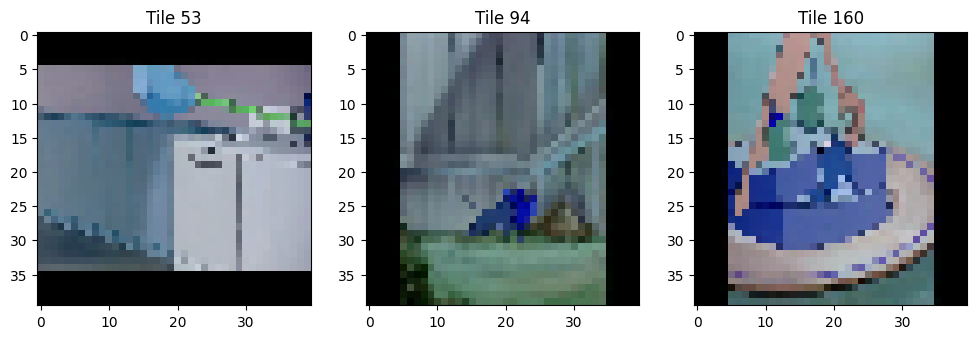

In [54]:
### START CODE HERE ###

# sample tile from list index
sample_tiles_idx = random.sample(list(np.arange(len(fnames_mini))), 3)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, tile_idx in zip(axes, sample_tiles_idx):
    ax.imshow(tiles[tile_idx])
    ax.set_title(f'Tile {tile_idx+1}')

plt.show()
### END CODE HERE ###

Calculate the average color for each tile image and add the resulting mean color to the `colors` list.

In [55]:
### START CODE HERE ###
colors = []
for tile in tiles:
  # np.mean(axis = (0, 1) -> mean by column)
  colors.append(np.mean(tile, axis = (0, 1)).astype(np.uint8))
colors = np.array(colors)

# print(colors[:10])
print(colors.shape)
### END CODE HERE ###

(179, 3)


Create a visual representation of the mean colors calculated for each tile image.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical
- Example output where `numImg = 10`

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/2-1.png)

- Example output where `numImg = 500`

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/2-2.png)
</details>

<class 'numpy.ndarray'>


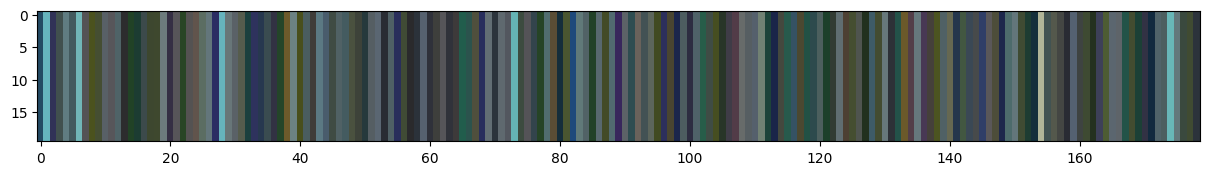

In [56]:
### START CODE HERE ###
num_images = len(colors)

# color_image -> image matrix 3 dimention (row, column, ch)
# create zero matrix
color_image = np.zeros((20, num_images, 3), dtype=np.uint8)
print(type(color_image))

# การคูณจะดู dimention หาก dimention เท่ากันจะคูณทุกตัวเข้าไปยังอีก dim
for i in range(len(colors)):
    color_image[:, i, :] = np.ones((20, 3)) * colors[i]
fig, axes = plt.subplots(1, 1, figsize=(15, 12))
axes.imshow(color_image)
plt.show()
### END CODE HERE ###

## Preparation for main image

Load the main image.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/3.png)

</details>

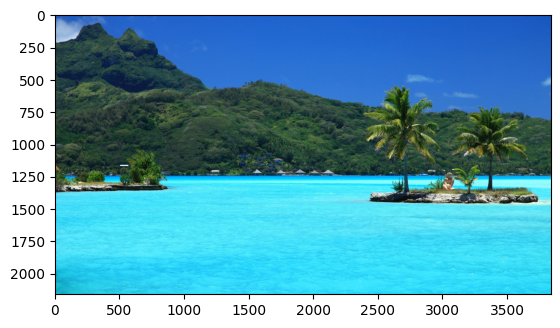

In [57]:
### START CODE HERE ###
# main image
img = cv2.imread("/content/drive/MyDrive/Image processing IMG/island.jpg")
og_img = img[:, :, ::-1]
main_img = og_img.copy()
plt.imshow(og_img)
### END CODE HERE ###

Compute the number of tiles required in the height and width dimensions of the image. This is based on the size of each tile and the dimensions of the original image. Define the dimensions for the resized image grid.

In [58]:
### START CODE HERE ###
height = og_img.shape[0] // tile_size[0]
width = og_img.shape[1] // tile_size[1]
dim = (height, width)
print(dim)
### END CODE HERE ###

(54, 96)


Visualize the resized image to ensure proper alignment with the tile grid.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/4.png)

</details>

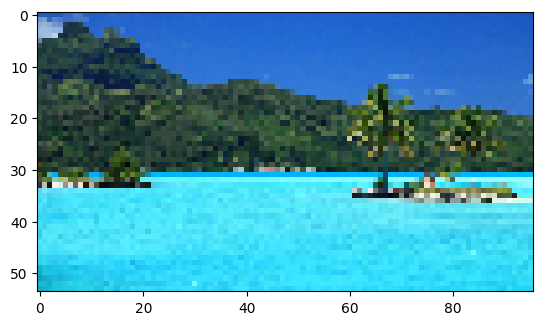

In [59]:
### START CODE HERE ###
# resize image = count tile image
resize_img = cv2.resize(main_img, (dim[1], dim[0]))
plt.imshow(resize_img)
### END CODE HERE ###

Create a KDTree from the list of mean colors of the tile images using [`spatial.KDTree()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html). Use `closest_tiles` to store the index of the closest tile image for each pixel in the resized main image.
***Try with difference value of k in `tree.query()`***

In [60]:
# create tree and create closest_tile matrix
tree = spatial.KDTree(colors)
closest_tiles = np.zeros(dim)

In [61]:
assert closest_tiles.shape == (height, width), "The shape of the closest_tiles array does not match the expected dimensions."

Visualizing `closest_tiles` Indices
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/5.png)

</details>

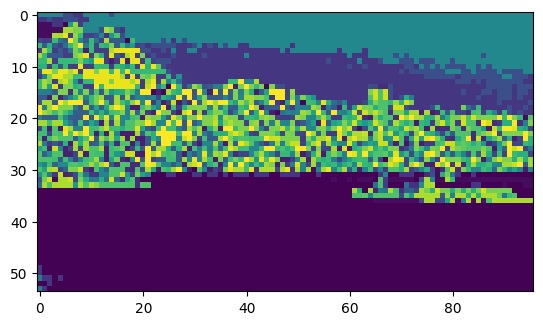

In [62]:
### START CODE HERE ###
# find tile color from total tile (54 * 96)
for i in range(height):
    for j in range(width):
        # tile[i, j] (tree.query(return -> distance, index in tree color))
        closest = tree.query(resize_img[i,j])
        closest_tiles[i,j] = closest[1]
# closest_tiles -> index from tree color
closest_tiles = closest_tiles.astype("uint8")
plt.imshow(closest_tiles)
### END CODE HERE ###

Create a copy of the resized main image and replace each pixel region with the corresponding tile image based on the closest tile indices to assemble the final photo mosaic.

In [63]:
### START CODE HERE ###
output = np.zeros_like(main_img)
for i in range(height):
    for j in range(width):
        #Offset
        x,y = i*tile_size[0] , j*tile_size[1]
        #index of tile
        index = closest_tiles[i,j]
        #draw tile
        output[x:(x+tile_size[0]) ,y:(y+tile_size[1]),: ] = tiles[index]
### END CODE HERE ###

Create a side-by-side comparison of four images: the original image, the resized main image, the final mosaic, and the KDTree tile index grid. This helps visualize the mosaic creation process.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/6.png)

</details>

In [64]:
### START CODE HERE ###
fig, axes = plt.subplots(1,4,figsize=(60,10))

axes[0].set_title("Original")
axes[0].imshow(main_img,aspect="auto")

axes[1].set_title("Main image feature")
axes[1].imshow(resize_img,aspect="auto")

axes[2].set_title("Mosaic")
axes[2].imshow(output,aspect="auto")

axes[3].set_title("KDTree Return Tile Index")
axes[3].imshow(closest_tiles,aspect="auto")
### END CODE HERE ###

Output hidden; open in https://colab.research.google.com to view.

## Save the final photo mosaic
Experiment with at least 3 different values of k and save the final photo.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- Saved output should resemble this, but not be identical

![image.gif](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab3_Image-Clustering/asset/7.gif?raw=true)


- k = 1

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/output-k1.png)

- k = 10

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/output-k10.png)

- k = 50

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/output-k50.png)
</details>

In [67]:
### START CODE HERE ###
def mosaic(k:int):
    closest_tiles = np.zeros(dim)
    for i in range(height):
        for j in range(width):
            closest = tree.query(resize_img[i,j],k=k)
            closest_tiles[i,j] = closest[1][k-1]
    closest_tiles = closest_tiles.astype("uint8")
    output = np.array(main_img)
    # print(np.array(closest).shape)

    for i in range(height):
        for j in range(width):
            #Offset
            x,y = i*tile_size[0] , j*tile_size[1]
            #index of tile
            index = closest_tiles[i,j]
            #draw tile
            output[x:(x+tile_size[0]) ,y:(y+tile_size[1]),: ] = tiles[index]
    return output

mosaic_3 = mosaic(3)
mosaic_5 = mosaic(5)
mosaic_11 = mosaic(11)
fig, axes = plt.subplots(1,4,figsize=(60,10))

axes[0].set_title("k=1")
axes[0].imshow(output,aspect="auto")

axes[1].set_title("k=3")
axes[1].imshow(mosaic_3,aspect="auto")

axes[2].set_title("k=5")
axes[2].imshow(mosaic_5,aspect="auto")

axes[3].set_title("k=11")
axes[3].imshow(mosaic_11,aspect="auto")


# Save the image using OpenCV
cv2.imwrite('output.png', output[:,:,::-1])  #
### END CODE HERE ###

Output hidden; open in https://colab.research.google.com to view.

---

## **Question**
1. How does changing the size of the tiles influence the overall quality and appearance of the mosaic? Conduct an analysis comparing two different tile sizes and discuss the trade-offs involved in terms of computational complexity and visual fidelity.
<br>
<u>ตอบ</u> ภาพของ tile size ใหญ่จะมีความละเอียดที่น้อย ภาพจะไม่ชัดเหมือนภาพแตกๆ ส่วนภาพของ tile size เล็กจะมีความละเอียดมาก รูปที่เห็นจะใกล้เคียงกับรูปดั้งเดิม  
<br>
<u>ข้อดีของ tile size ใหญ่</u> : คือ คำนวณเร็ว เนื่องจาก iteration น้อย  <u>ข้อเสีย</u> : คือ ได้รูป mosaic ที่มีความละเอียดต่ำ
<br>
<u>ข้อเสียของ tile size เล็ก</u> : คือ คำนวณช้า เนื่องจาก iteration ในการเทียบ pixel มากกว่า
<u>ข้อดี</u> คือ ได้รูป  mosaic ที่มีความเที่ยงตรงใกล้เคียงกับรูปเดิม ควาามละเอียดของรูปสูง
2. Explain the effect of changing the value of K (number of nearest neighbors) on the mosaic image.
<br>
<u>ตอบ</u> การเพิ่มค่า k จะทำให้ภาพที่ได้เพี้ยนไปจาก mosaic ที่ค่า k เป็น 1 เนื่องจาก เมื่อ k > 1 เราจะทำการเลือกจุดที่ใกล้ที่สุด k จุดแล้วทำ majority vote คือดูว่าใน k จุดนี้มี class ไหนที่จุด k จุดอยู่เยอะที่สุด ก็จะ return class นั้นมาใช้ ด้วยเหตุนี้เอง ทำให้เมื่อมีจุดที่ใกล้เคียงที่มีจำนวนน้อยกว่าจุดที่ไม่ใกล้เคียงจำนวนมากนั้น การทำ majority vote k เยอะ อาจจะทำให้ไปเลือก class ที่จุดสีที่ไม่ใกล้เคียงอยู่มากกว่าได้ ดังตัวอย่างการใช้ค่า k > 1 ด้านล่าง(จำลองตามสิ่งที่ควรเป็น) จะเห็นว่าภาพมีสีที่เพี้ยนไปเมื่อค่า k มากขึ้น
